# Model-Agnostic Meta-Learning
In this homework, we will learn and implement MAML algorithm from scratch through two toy examples: a regression task and a classification task.

# Part 1: Regression on Sine Waves [40 pts]
Following our lecture slides, we will use a simple regression task to illustrate the basic principles of MAML.

The goal is to best fit a sine curve by using a very small number of data points sampled from the curve.
To achieve this few-shot learning goal, we need to apply MAML to learn an optimal initialization of the regressor from a series of (Totally 1,000 in our case) training tasks.

Each training task will repeat:
1. Given a target sine curve $y = a sin (x + b)$;

2. Sample $k=10$ data points from the target sine curve;

3. Use the data samples to estimate $a$ and $b$.


The range of amplitude: $a \in [0.1,0.5]$. The range of phase: $b \in [0,\pi]$. The input $x$ are uniformly sampled from $[-5.0,5.0]$.

In [1]:
#import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Generate sinusoid datasets

In [3]:
class SineTask():
    def __init__(self,amp,phase,min_x,max_x):
        self.phase=phase # Sine wave phase
        self.max_x=max_x
        self.min_x=min_x
        self.amp=amp # Sine wave amplitude

    def sample_data(self,size=1):
        x=np.random.uniform(self.max_x,self.min_x,size)
        y=self.true_sine(x)
        x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
        return x,y

    def true_sine(self,x):
        y=self.amp*np.sin(self.phase+x)
        return y

class SineDistribution():
    def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
        self.min_amp=min_amp
        self.max_phase=max_phase
        self.min_phase=min_phase
        self.max_amp=max_amp
        self.min_x=min_x
        self.max_x=max_x

    def sample_task(self):
        amp = np.random.uniform(self.min_amp, self.max_amp)
        phase = np.random.uniform(self.min_phase, self.max_phase)
        return SineTask(amp, phase, self.min_x, self.max_x)

### Train the regression model

we will apply MAML to learn an optimal initialization of the regressor from 1,000 training tasks (sine curves).

#### Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [4]:
in_features = 1
hidden_size = 40
out_features = 1

In [5]:
# Define SineNet
class SineNet(nn.Module):
    def __init__(self):
        super(SineNet,self).__init__()
        self.net=nn.Sequential(OrderedDict([
            # INSERT CODE HERE
            ('l1', nn.Linear(in_features, hidden_size)),
            ('r1', nn.ReLU()),
            ('l2', nn.Linear(hidden_size, hidden_size)),
            ('r2', nn.ReLU()),
            ('l3', nn.Linear(hidden_size, out_features))
            # END CODE HERE
            ]))

    def forward(self,x):
        return self.net(x)

    # Assign 'weights' to the model. This function is useful to compute the adapted(fast) parameters in inner-loop
    def argforward(self,x,weights):
        x=F.linear(x,weights[0],weights[1])
        x=F.relu(x)
        x=F.linear(x,weights[2],weights[3])
        x=F.relu(x)
        x=F.linear(x,weights[4],weights[5])
        return x

#### Training implementation

In [6]:
# Define implementation class
class SineMAML():
    def __init__(self,net,alpha,beta,tasks,k,num_metatasks):
        self.net=net
        self.weights=list(net.parameters())
        self.alpha=alpha
        self.beta=beta
        self.tasks=tasks
        self.k=k
        self.num_tasks_meta=num_metatasks
        self.criterion=nn.MSELoss() # Define the loss function
        self.meta_optimiser=torch.optim.Adam(self.weights,self.beta) # Define the optimizer
        self.meta_losses=[] # Collect the training loss for visulization
        self.plot_every =1  # loss plot interval
        self.print_every = 5 # loss print interval
        self.num_metatasks=num_metatasks

    def inner_loop(self,task):
        temp_weights=[w.clone() for w in self.weights] # Get initial model weights. 'temp_weights' is used to compute adapted(fast) weights
        x,y=task.sample_data(size=self.k) # Sample K-shot data of the task as training set
        x=x.to(device)
        y=y.to(device)

        # Meta-train and get updated 'temp_weights'
        # INSERT CODE HERE
        steps=5
        for i in range(steps):
          pred = self.net.argforward(x, temp_weights)
          loss = self.criterion(pred, y)
          grad = torch.autograd.grad(loss, temp_weights)
          temp_weights = [w - self.alpha * g for w, g in zip(temp_weights, grad)]

        # END CODE HERE

        x,y=task.sample_data(size=self.k) # Sample K-shot data of the task as validation set
        x=x.to(device)
        y=y.to(device)

        # Meta-validate using the new 'temp_weights' and compute 'metaloss'
        # INSERT CODE HERE
        pred = self.net.argforward(x, temp_weights)
        metaloss = self.criterion(pred, y)
        # END CODE HERE

        return metaloss

    def outer_loop(self,num_epochs):
        total_loss=0
        for epoch in range(1,num_epochs+1):
            metaloss_sum=0

            # Meta-train and meta-validate on each task
            for i in range(self.num_metatasks):
                task=self.tasks.sample_task()
                metaloss=self.inner_loop(task)
                metaloss_sum+=metaloss

            # Meta-update using 'metaloss_sum'
            # INSERT CODE HERE
            self.meta_optimiser.zero_grad()
            metaloss_sum.backward()
            self.meta_optimiser.step()
            # END CODE HERE

            total_loss+=metaloss_sum.item()/self.num_metatasks
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
            if epoch%self.plot_every==0:
                self.meta_losses.append(total_loss/self.plot_every)
                total_loss = 0
            if (epoch%100)==0:
                print("Epoch "+str(epoch)+" completed.")

#### Train the model

In [7]:
sine_tasks=SineDistribution(0.1, 5, 0, np.pi, -5, 5)
net=SineNet()
net=net.to(device)
maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=10,num_metatasks=1000)

In [8]:
# Train the model for 100 epoches
maml.outer_loop(num_epochs=50)

5/50. loss: 3.969467041015625
10/50. loss: 3.479962158203125
15/50. loss: 3.493092529296875
20/50. loss: 3.52473681640625
25/50. loss: 3.212779541015625
30/50. loss: 3.350573974609375
35/50. loss: 3.162718994140625
40/50. loss: 3.252583984375
45/50. loss: 3.329578857421875
50/50. loss: 2.9627578125


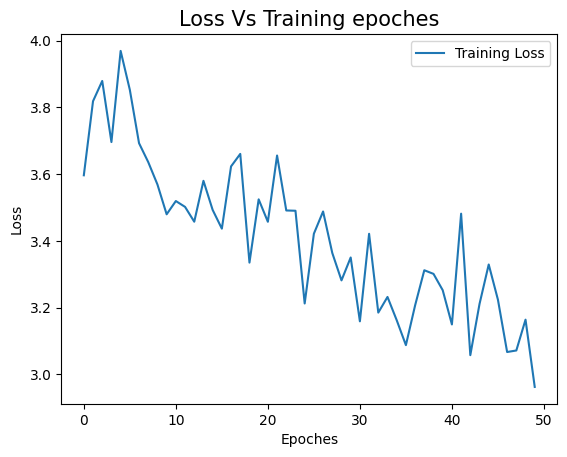

In [9]:
# Plot the training loss
plt.plot(maml.meta_losses,  label="Training Loss")
plt.title('Loss Vs Training epoches', fontsize=15)
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Test the regression model

After training, we have learned an optimal initialization for the regressor. At testing time, we expect the regressor can quickly fit a new sine curver using few-shot (e.g. 10) data examples.

In [10]:
# Test the meta-learned model
def test(og_net,x,y,lr,optim=torch.optim.SGD):
    axis=np.linspace(-5,5,1000)
    axis=torch.tensor(axis,dtype=torch.float)
    axis=axis.to(device)
    dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    dummy_net=dummy_net.to(device)
    dummy_net.load_state_dict(og_net.state_dict()) # Load initial weights
    loss_fn=nn.MSELoss()
    opt=optim(dummy_net.parameters(),lr=lr)
    steps=10 # Number of steps to fine-tune the meta-learned model
    k=x.shape[0]
    losses=[]
    outputs={}

    # Fine-tune the meta-learned model on the new task
    for _ in range(steps):
        # INSERT CODE HERE
        opt.zero_grad()
        pred = dummy_net(x.view(-1, 1))
        loss = loss_fn(pred, y.view(-1, 1))
        loss.backward()
        opt.step()
        losses.append(loss.item())
        # END CODE HERE

    # Results of the fine-tuned model
    outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
    # Results of the model without fine-tuning
    outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
    return outputs,axis


In [11]:
# Plot the comparison results
def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
    outputs,axis=test(og_net,x,y,lr,optim)
    plt.figure(figsize=(10,5))
    plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true sine')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
    plt.legend(loc='lower right')
    plt.show()

<ipython-input-10-5a0218f468c2>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


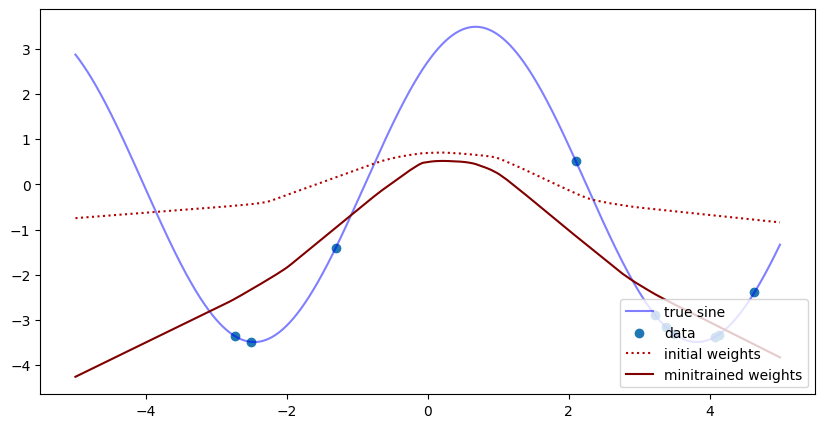

In [12]:
K=10 # Batchsize for the new task
task=sine_tasks.sample_task() # Sample a new sine wave as new task
x,y=task.sample_data(K) # Sample K-shot data from the task
x=x.to(device)
y=y.to(device)
# Visualized the true sine, predicted sine of the fine-tuned model, and predicted sine of the model without fine-tuning
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

# Part 2: Classification on Omniglot [60 pts]
Following our lecture slides of few-shot classification, we will leverage MAML to learn a Convolutional Neural Network on the Omniglot dataset.

The Omniglot Dataset can be found: https://github.com/brendenlake/omniglot. We will use "images_background" for training and "images_evaluation" for test.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:

# for Google Colab

%cd "/content/drive/MyDrive/HW5/HWDATA/Data"



/content/drive/MyDrive/HW5/HWDATA/Data


In [15]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [16]:
# for Google Colab; change the path accordingly if you run locally
trainframe=pd.read_csv("/content/drive/MyDrive/HW5/HWDATA/Data/test_data.csv")
testframe=pd.read_csv("/content/drive/MyDrive/HW5/HWDATA/Data/test_data.csv")


In [17]:
trainframe.head()

,ID,Path,Label
0,0965_01.png,Data/images_evaluation/Angelic/character01/096...,964
1,0965_02.png,Data/images_evaluation/Angelic/character01/096...,964
2,0965_03.png,Data/images_evaluation/Angelic/character01/096...,964
3,0965_04.png,Data/images_evaluation/Angelic/character01/096...,964
4,0965_05.png,Data/images_evaluation/Angelic/character01/096...,964


In [18]:
testframe.head()

,ID,Path,Label
0,0965_01.png,Data/images_evaluation/Angelic/character01/096...,964
1,0965_02.png,Data/images_evaluation/Angelic/character01/096...,964
2,0965_03.png,Data/images_evaluation/Angelic/character01/096...,964
3,0965_04.png,Data/images_evaluation/Angelic/character01/096...,964
4,0965_05.png,Data/images_evaluation/Angelic/character01/096...,964


In [19]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
# Define tasks used for training and test
class Task(object):
    def __init__(self,all_classes,num_classes,num_instances):
        self.all_classes=all_classes
        self.num_classes=num_classes
        self.num_instances=num_instances
        self.train_roots=[]
        self.meta_roots=[]
        self.train_labels=[]
        self.meta_labels=[]
        samples_per_class=20
        sampled_classes=random.sample(all_classes,num_classes)
        label=0
        for c in sampled_classes:
            cframe=trainframe.iloc[(c*samples_per_class):((c+1)*samples_per_class)]
            cframe.reset_index(inplace=True,drop=True)
            paths=cframe["Path"]
            sample_idxs=np.random.choice(samples_per_class,samples_per_class,replace=False)
            train_idxs=sample_idxs[:num_instances]
            meta_idxs=sample_idxs[num_instances:(num_instances*2)]
            for idx in train_idxs:
                self.train_roots.append(paths[idx])
                self.train_labels.append(label)
            for idx in meta_idxs:
                self.meta_roots.append(paths[idx])
                self.meta_labels.append(label)
            label+=1

class TestTask(object):
    def __init__(self,all_classes,num_classes,num_instances,num_test_instances):
        self.all_classes=all_classes
        self.num_classes=num_classes
        self.num_instances=num_instances
        self.num_test_instances=num_test_instances
        self.test_roots=[]
        self.train_roots=[]
        self.test_labels=[]
        self.train_labels=[]
        samples_per_class=20
        sampled_classes=random.sample(all_classes,num_classes)
        label=0

        for c in sampled_classes:
            cframe=testframe.iloc[((c-964)*samples_per_class):(((c+1)-964)*samples_per_class)]
            cframe.reset_index(inplace=True,drop=True)
            paths=cframe["Path"]
            sample_idxs=np.random.choice(samples_per_class,samples_per_class,replace=False)
            train_idxs=sample_idxs[:num_instances]
            test_idxs=sample_idxs[num_instances:(num_instances+num_test_instances)]
            for idx in test_idxs:
                self.test_roots.append(paths[idx])
                self.test_labels.append(label)
            for idx in train_idxs:
                self.train_roots.append(paths[idx])
                self.train_labels.append(label)
            label+=1

In [21]:
# Construct dataset
class MiniSet(Dataset):
    def __init__(self,fileroots,labels,transform):
        self.fileroots=fileroots
        self.labels=labels
        self.transform=transform

    def __len__(self):
        return len(self.fileroots)

    def __getitem__(self,idx):
        img=Image.open(self.fileroots[idx])
        img=self.transform(img)
        return img,self.labels[idx]

In [22]:
# Construct dataloader for training set and test set
transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
def get_loaders(task):
    loaders={}
    train_fileroots=task.train_roots
    train_labels=task.train_labels
    meta_fileroots=task.meta_roots
    meta_labels=task.meta_labels
    trainloader=DataLoader(MiniSet(train_fileroots,train_labels,transform),
                         batch_size=len(train_fileroots),shuffle=True)
    metaloader=DataLoader(MiniSet(meta_fileroots,meta_labels,transform),
                         batch_size=len(meta_fileroots),shuffle=True)
    loaders["train"]=trainloader
    loaders["meta"]=metaloader
    return loaders

def get_test_loaders(task):
    loaders={}
    test_fileroots=task.test_roots
    test_labels=task.test_labels
    train_fileroots=task.train_roots
    train_labels=task.train_labels
    testloader=DataLoader(MiniSet(test_fileroots,test_labels,transform),
                         batch_size=len(test_fileroots),shuffle=True)
    trainloader=DataLoader(MiniSet(train_fileroots,train_labels,transform),
                         batch_size=len(train_fileroots),shuffle=True)
    loaders["train"]=trainloader
    loaders["test"]=testloader
    return loaders

In [23]:
# Define the classification model
class BaseNet(nn.Module):
    def __init__(self,num_classes):
        super(BaseNet,self).__init__()
        self.features = nn.Sequential(OrderedDict([
                    ('conv1', nn.Conv2d(1, 64, 3)),
                    ('bn1', nn.BatchNorm2d(64, momentum=1, affine=True)),
                    ('relu1', nn.ReLU(inplace=True)),
                    ('pool1', nn.MaxPool2d(2,2)),
                    ('conv2', nn.Conv2d(64,64,3)),
                    ('bn2', nn.BatchNorm2d(64, momentum=1, affine=True)),
                    ('relu2', nn.ReLU(inplace=True)),
                    ('pool2', nn.MaxPool2d(2,2)),
                    ('conv3', nn.Conv2d(64,64,3)),
                    ('bn3', nn.BatchNorm2d(64, momentum=1, affine=True)),
                    ('relu3', nn.ReLU(inplace=True)),
                    ('pool3', nn.MaxPool2d(2,2))]))
        self.add_module('fc', nn.Linear(64,num_classes))

    def forward(self,x,weights=None):
        if weights==None:
            output=self.features(x)
            output=output.view(-1,64)
            output=self.fc(output)
        else:
            x = F.conv2d(x, weights['meta_learner.features.conv1.weight'], weights['meta_learner.features.conv1.bias'])
            x = F.batch_norm(x, weights['meta_learner.features.bn1.running_mean'],
                             weights['meta_learner.features.bn1.running_var'],
                              weights['meta_learner.features.bn1.weight'],
                             weights['meta_learner.features.bn1.bias'],momentum=1,training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = F.conv2d(x, weights['meta_learner.features.conv2.weight'], weights['meta_learner.features.conv2.bias'])
            x = F.batch_norm(x, weights['meta_learner.features.bn2.running_mean'],
                             weights['meta_learner.features.bn2.running_var'],
                              weights['meta_learner.features.bn2.weight'],
                             weights['meta_learner.features.bn2.bias'],momentum=1,training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = F.conv2d(x, weights['meta_learner.features.conv3.weight'], weights['meta_learner.features.conv3.bias'])
            x = F.batch_norm(x, weights['meta_learner.features.bn3.running_mean'],
                             weights['meta_learner.features.bn3.running_var'],
                              weights['meta_learner.features.bn3.weight'],
                             weights['meta_learner.features.bn3.bias'],momentum=1,training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = x.view(x.size(0), 64)
            output = F.linear(x, weights['meta_learner.fc.weight'], weights['meta_learner.fc.bias'])
        out = F.log_softmax(output, dim=1)
        return out

In [24]:
# Define MetaLearner to organize the meta-training framework
class MetaLearner(nn.Module):
    def __init__(self,num_classes):
        super(MetaLearner, self).__init__()
        self.meta_learner=BaseNet(num_classes)

    def forward(self,x,mod_weights=None):
        if mod_weights==None:
            out=self.meta_learner(x)
        else:
            out=self.meta_learner(x,mod_weights)
        return out

    def clone_state_dict(self):
        cloned_state_dict = {key: val.clone()for key, val in self.state_dict().items()}
        return cloned_state_dict

In [25]:
def inner_loop(net,lr,loaders,num_updates,loss_metric):
    net.train()
    trainloader=iter(loaders["train"])
    x,y=next(trainloader)
    x.to(device)
    y.to(device)
    output=net(x)
    loss=loss_metric(output,y)

    # Set the gradients of all parameters to zero
    def zero_grad(params):
        # INSERT CODE HERE
        for i in params:
          if i.grad is not None:
            i.grad.zero_()
        # END CODE HERE

    # Meta-train

    # INSERT CODE HERE
    for _ in range(num_updates):
        zero_grad(net.parameters())
        output = net(x)
        loss = loss_metric(output, y)
        loss.backward()
        grads = [param.grad for param in net.parameters()]

    # END CODE HERE

    mod_state_dict=net.clone_state_dict() # Used to store adapted(fast) weights
    mod_weights=OrderedDict() # adapted(fast) weights
    for (k,v),g in zip(net.named_parameters(),grads):
        mod_weights[k]=v-lr*g
        mod_state_dict[k]=mod_weights[k]

    return mod_state_dict

In [26]:
def outer_loop(net,meta_train_classes,meta_optimiser,loss_metric,num_classes,num_instances,num_tasks,lr,meta_lr,num_inner_updates,num_epochs):
    total_loss= 0
    print_every= 10
    plot_every= 1
    meta_losses=[]
    for epoch in range(1,num_epochs+1):
        state_dicts=[]
        loaders_list=[]

        for n in range(num_tasks):
            task=Task(meta_train_classes,num_classes,num_instances)
            loaders=get_loaders(task)
            d=inner_loop(net,lr,loaders,num_inner_updates,loss_metric)
            state_dicts.append(d)
            loaders_list.append(loaders)

        metaloss=0

        # Meta-validation on each task
        for n in range(num_tasks):
            loaders=loaders_list[n]
            metaloader = iter(loaders["meta"])
            x, y = next(metaloader)
            x.to(device)
            y.to(device)

            # Compute 'metaloss'
            # INSERT CODE HERE
            net.load_state_dict(state_dicts[n])
            net.eval()
            with torch.no_grad():
                output = net(x)
                task_loss = loss_metric(output, y)
                metaloss += task_loss
            # END CODE HERE

        metaloss/=float(num_tasks)
        total_loss+=metaloss.item()

        if epoch % print_every == 0:
            print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / plot_every))
        if epoch%plot_every==0:
            meta_losses.append(total_loss/plot_every)
            total_loss = 0
        if (epoch%20)==0:
            print("Epoch "+str(epoch)+" completed.")
    return meta_losses,net

In [ ]:
loss_metric=nn.NLLLoss()
num_classes=5 # Number of classes for each task
net=MetaLearner(num_classes)
lr=1e-1 # Learning rate for inner loop
meta_lr=1e-3 # Learning rate for outer loop
meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
num_instances=3 # Number of instances for each class
num_tasks=10 # Number of tasks for each mini-batch
num_inner_updates=1
num_epochs=100
train_classes=np.max(trainframe['Label'])
train_classes=list(np.arange(train_classes))
metalosses,net=outer_loop(net,train_classes,meta_optimizer,loss_metric,num_classes,num_instances,num_tasks,lr,meta_lr,num_inner_updates,num_epochs)

10/100. loss: 1.3875720500946045
20/100. loss: 1.3555307388305664
Epoch 20 completed.
30/100. loss: 1.3339799642562866
40/100. loss: 1.3775752782821655
Epoch 40 completed.
50/100. loss: 1.4193737506866455
60/100. loss: 1.4783642292022705
Epoch 60 completed.
70/100. loss: 1.4350231885910034
80/100. loss: 1.4550557136535645
Epoch 80 completed.
90/100. loss: 1.499338150024414
100/100. loss: 1.4168598651885986
Epoch 100 completed.


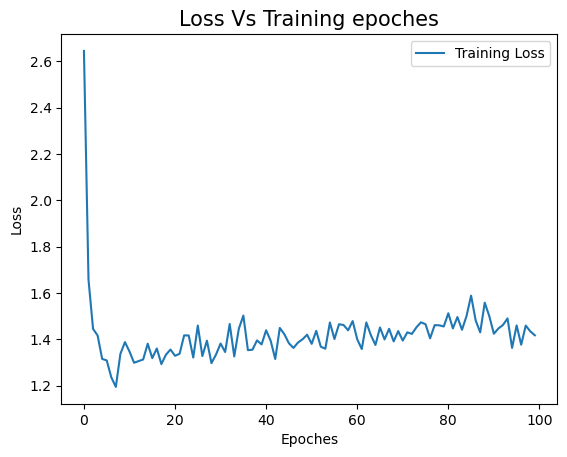

In [ ]:
# Plot the training loss
plt.plot(metalosses,  label="Training Loss")
plt.title('Loss Vs Training epoches', fontsize=15)
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Calculate classification accuracy
def accuracy(outputs, labels):
    outputs = np.argmax(outputs, axis=1)
    return np.sum(outputs == labels) / float(labels.size)

In [ ]:
# Test the meta-learned model
import copy
def test(net,test_classes,task_lr,num_classes=5,num_steps=100,num_test_updates=3):
    losses=[]
    acc_list=[]
    for step in np.arange(num_steps):
        task=TestTask(test_classes,num_classes=5,num_instances=3,num_test_instances=10) # Get test task
        loaders=get_test_loaders(task)
        trainloader,testloader=loaders["train"],loaders["test"]
        x_train,y_train=next(iter(trainloader)) # Get training data (support set) from the task
        x_test,y_test=next(iter(testloader)) # Get test data (query set) from the task
        x_train.to(device)
        y_train.to(device)
        x_test.to(device)
        y_test.to(device)
        cloned_net=copy.deepcopy(net)
        optim = torch.optim.SGD(cloned_net.parameters(),lr=task_lr)

        # Fine-tune the meta-learned model on test tasks
        for _ in range(num_test_updates):
            # INSERT CODE HERE
            optim.zero_grad()
            y_train_pred = cloned_net(x_train)
            loss = loss_metric(y_train_pred, y_train)
            loss.backward()
            optim.step()
            # END CODE HERE

        y_test_pred=cloned_net(x_test)
        loss=loss_metric(y_test_pred,y_test)
        losses.append(loss)
        y_test_pred=y_test_pred.data.cpu().numpy()
        y_test=y_test.data.cpu().numpy()
        acc=accuracy(y_test_pred,y_test)
        acc_list.append(acc)
    return acc_list,losses

In [ ]:
# Test the meta-learned model and get testing accuracy
test_classes=list(np.arange(np.min(testframe['Label']),np.max(testframe['Label']+1)))
acc_list,losses=test(net,test_classes,task_lr=1e-1)
average_test_accuracy=(sum(acc_list)/len(acc_list))
print('Average test accuracy', average_test_accuracy)

Average test accuracy 0.4442000000000001
